# Hierarchische Verfahren
Hierarchische Clusterverfahren konvertieren Daten in eine hierarchische Repräsentation, aus der die Clusterstruktur abgeleitet werden kann. Zugehörigen Algorithmen benötigen keine vorher festgelegte Anzahl an Clustern.

In [ ]:
import math
from itertools import product

from tui_dsmt.clustering import kmeans, AgglomerativeClustering, DivisiveClustering
from tui_dsmt.clustering.datasets import clustering_example3

## Inhaltsverzeichnis
- [Dendrogramme](#Dendrogramme)
- [Distanzfunktionen für Cluster](#Distanzfunktionen-für-Cluster)
- [Agglomeratives hierarchisches Clustering](#Agglomeratives-hierarchisches-Clustering)
- [Divisives hierarchisches Clustering](#Divisives-hierarchisches-Clustering)
- [Ergebnisse aus dem Dendrogramm](#Ergebnisse-aus-dem-Dendrogramm)
- [Chaining-Problem](#Chaining-Problem)

## Dendrogramme
Ein Dendrogramm ist ein Diagramm, das verwendet wird, um die Ergebnisse eines hierarchischen Clustering-Verfahrens darzustellen. Es zeigt die hierarchische Struktur der Cluster und die Beziehungen zwischen diesen visuell. Beim Dendrogramm handelt es sich um einen Baum, dessen Knoten jeweils ein Cluster repräsentieren und für den folgende Eigenschaften gelten:
- Die Wurzel repräsentiert die ganze Datenbank. (Ein einzelnes Cluster, das alle Objekte umfasst.)
- Blätter repräsentieren einzelne Objekte. (Das kleinstmögliche Cluster enthält jeweils genau ein Objekt.)
- Innere Knoten repräsentieren die Vereinigung von Clustern, die im darunterliegenden Teilbaum repräsentiert werden.

**Beispiel:** Nachfolgend sind neun Punkte und ein aus diesen entstehendes Dendrogramm gegeben.

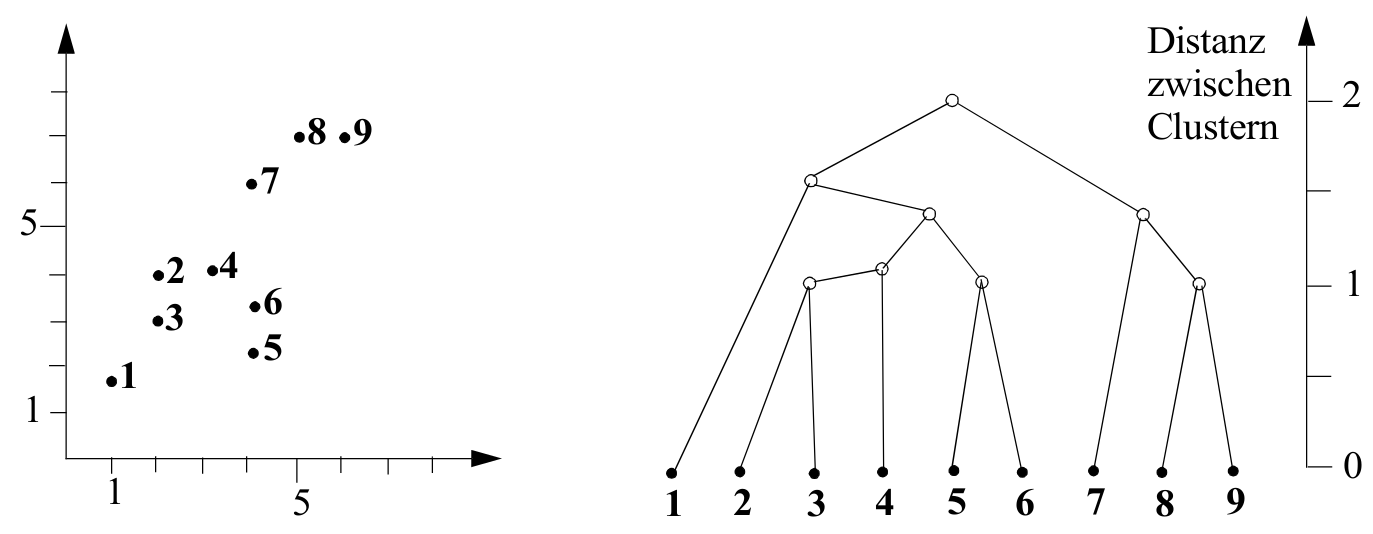

Die Konstruktionsrichtung des Dendrogramms teilt die hierarchischen Verfahren in zwei Kategorien:
- **Agglomerative** Algorithmen konstruieren das Dendrogramm von unten nach oben. (Bottom-Up)
- **Divisive** Algorithmen konstruieren das Dendrogramm von oben nach unten. (Top-Down)

## Distanzfunktionen für Cluster
In einem anderen Abschnitt wurden bereits Distanzmaße zwischen Objekten vorgestellt. Für die nachfolgenden Algorithmen muss jedoch der Abstand zweier Cluster, die Mengen von Objekten darstellen, berechnet werden. Für die Berechnung der Distanz zwischen den Clustern $X$ und $Y$ und einer Abstandsfunktion zwischen Objekten $dist$ können beispielsweise die nachfolgenden drei Funktionen verwendet werden:

- **Single-Link:** $$dist_{sl}(X, Y) = \underset{x \in X, y \in Y}{\min} dist(x, y)$$
- **Complete-Link:** $$dist_{cl}(X, Y) = \underset{x \in X, y \in Y}{\max} dist(x, y)$$
- **Average-Link:** $$dist_{al}(X, Y) = \frac{1}{\left| X \right| * \left| Y \right|} * \sum_{x \in X, y \in Y} dist(x, y)$$

Für die Verwendung in Beispielen notieren wir die Umsetzung außerdem in Python.

In [ ]:
def cluster_dist(l, r):
    for (x1, y1), (x2, y2) in product(l, r):
        yield math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def single_link(l, r):
    return min(cluster_dist(l, r))

def complete_link(l, r):
    return max(cluster_dist(l, r))

def average_link(l, r):
    return sum(cluster_dist(l, r)) / (len(l) * len(r))

## Agglomeratives hierarchisches Clustering
Agglomeratives hierarchisches Clustering ist ein Verfahren, das mit jedem Datenpunkt als eigenem Cluster beginnt und ähnliche Cluster schrittweise fusioniert, um eine Cluster-Hierarchie zu erstellen. Es benötigt ein Distanzmaß, um die Ähnlichkeit **zwischen Clustern** zu bestimmen. Die Fusion erfolgt iterativ, bis alle Datenpunkte zu einem einzigen Cluster verschmolzen sind.

Beispielhaft soll der Single-Link Algorithmus betrachtet werden. Dieser funktioniert wie folgt:
1. Jedem Objekt wird ein einzelnes Cluster zugeordnet. (Diese sind bereits Teil der Ergebnismenge.)
2. Es wird eine Kandidatenmenge erstellt, die alle erstellten Cluster enthält.
3. Solange die Kandidatenmenge noch mindestens zwei Cluster enthält:
    1. Zwischen allen Paaren von Clustern wird die Distanz bestimmt und das Paar herausgesucht, das den geringsten Abstand im Sinne der verwendeten Distanzfunktion für Cluster zueinander besitzt.
    2. Ein neuer Cluster wird durch Vereinigung des Paares bestimmt und ins Ergebnis aufgenommen.
    3. Die beiden Cluster werden aus der Menge der Kandidatenmenge entfernt. Der neue Cluster wird der Kandidatenmenge hinzugefügt.

Zunächst wird eine Funktion eingeführt, die aus einer Menge von Clustern genau das Paar findet, das den geringsten Abstand zueinander besitzt:

In [ ]:
def min_dist_clusters(clusters, dist=average_link):
    _, (c1, c2) = min(
        (dist(l, r), (l, r)) for l in clusters for r in clusters if l != r
    )

    return c1, c2

Das agglomeratives hierarchische Clustering lässt sich dann formulieren:

In [ ]:
# Die Ergebnismenge enthält zunächst alle
# Cluster, die aus jeweils einem Punkt
# gebildet werden.
result = [((x, y),) for _, (x, y) in clustering_example3.iterrows()]

# Die Kandidatenmenge enthält zu Beginn
# die selben Cluster.
candidates = set(result)

# Solange noch mindestens zwei Kandidaten
# vorhanden sind...
while len(candidates) >= 2:
    # wird das Paar mit dem geringsten
    # Abstand gesucht,
    c1, c2 = min_dist_clusters(candidates)

    # zu einem neuen Cluster vereeinigt
    new_cluster = c1 + c2
    result.append(new_cluster)

    # aus der Kandidatenmenge entfernt
    # und der neue Cluster dieser
    # wiederum hinzugefügt.
    candidates.remove(c1)
    candidates.remove(c2)
    candidates.add(new_cluster)

result

Grafisch dargestellt lässt sich erkennen, dass die Cluster langsam miteinander verschmolzen werden. Die Reihenfolge hängt von der Distanz ab. Probieren Sie daher auch verschiedene Distanzfunktionen aus.

In [ ]:
AgglomerativeClustering(clustering_example3, dist=average_link)

Ein positiver Aspekt dieser Methode ist, dass sie keine vorherige Kenntnis über die Anzahl der Cluster erfordert und eine vollständige Hierarchie an Clustern liefert. Jedoch weist das Bottom-up Clustering auch einige Nachteile auf. Entscheidungen, die während des Zusammenführens von Clustern getroffen werden, können nicht rückgängig gemacht werden, und es ist anfällig für Rauschen, insbesondere bei der Verwendung von Single-Link. Zudem ist die Methode ineffizient mit einer Laufzeitkomplexität von mindestens $O(n^2)$.

## Divisives hierarchisches Clustering
Während das agglomerative Clustering von einzelnen Punkten ausgeht und sie schrittweise zu größeren Gruppen fusioniert, beginnt das divisive Clustering mit einer einzigen Gruppe, die alle Datenpunkte enthält, und teilt diese Gruppe dann in kleinere Untergruppen auf, bis jede Gruppe nur noch aus einem einzigen Datenpunkt besteht. Erneut wird dazu ein Distanzmaß verwendet, das den Abstand **zwischen Clustern** bestimmt.

Der Algorithmus funktioniert wie folgt:
1. Ein einzelner Cluster, der alle Punkte beinhaltet, wird erzeugt. Dieser gehört zur Ergebnismenge.
2. Die Kandidatenmenge wird mit dem erzeugten Cluster initialisiert.
3. Solange noch Kandidaten vorhanden sind:
    1. Der Kandidat mit der größten enthaltenen Unähnlichkeit wird herausgesucht.
    2. Der gefundene Cluster wird in zwei neue Cluster aufgespalten.
    3. Die neuen Cluster werden dem Ergebnis hinzugefügt.
    4. Der Kandidat wird aus der Kandidatenmenge entfernt und die eben erzeugten Cluster dieser hinzugefügt, sofern sie mehr als ein Element enthalten.

Zur Berechnung der Unähnlichkeit innerhalb eines Clusters können verschiedene Maße herangezogen werden. Eine einfache ist die Summe der quadrierten Fehler (*SSE*).

In [ ]:
def sse(cluster):
    x_mean = sum(x for x, _ in cluster) / len(cluster)
    y_mean = sum(y for _, y in cluster) / len(cluster)

    sum_of_squared_error = 0
    for x, y in cluster:
        sum_of_squared_error += (x - x_mean) ** 2 + (y - y_mean) ** 2

    return sum_of_squared_error

def max_sse_cluster(clusters):
    return max(clusters, key=sse)

Die Aufspaltung eines Clusters kann durch einen einfacheren Clustering-Algorithmus wie beispielsweise k-Means erfolgen.

In [ ]:
# Die Ergebnismenge enthält zunächst einen
# großen Cluster, der alle Punkte enthält.
result = [tuple((x, y) for _, (x, y) in clustering_example3.iterrows())]

# Die Kandidatenmenge enthält zu Beginn
# genau diesen Cluster.
candidates = set(result)

# Solange noch Kandidaten vorhanden sind...
while len(candidates) >= 1:
    # wird der Kandidat mit der größten
    # enthaltenen Unähnlichkeit gesucht,
    c = max_sse_cluster(candidates)

    # mit Hilfe von k-Means aufgespalten,
    c1, c2 = kmeans(c, k=2)

    # die entstehenden Cluster dem Ergebnis
    # hinzugefügt
    result.append(c1)
    result.append(c2)

    # und die Kandidatenmenge angepasst.
    candidates.remove(c)

    if len(c1) > 1:
        candidates.add(c1)
    if len(c2) > 1:
        candidates.add(c2)

result

Auch das divisive hierarchische Clustering können Sie mit den verschiedenen Distanzfunktionen vergleichen.

In [ ]:
DivisiveClustering(clustering_example3, dist=average_link)

Das divisive Clustering ist im Allgemeinen rechenaufwendiger als das agglomerative Clustering, da es eine große Anzahl von Iterationen durchführen kann, insbesondere wenn die Anzahl der Datenpunkte hoch ist.

## Ergebnisse aus dem Dendrogramm
Aus dem Dendrogramm lässt sich ablesen, in welcher Reihenfolge ein Algorithmus zwei Cluster vereinigt bzw. einen Cluster aufspaltet. Die Länge der Verzweigungen lässt zudem einen Rückschluss auf die Abstände bzw. auf geringere Ähnlichkeit zweier vereinigter Cluster zu.

Um ein Clustering durchzuführen, muss nun ein Distanzwert gewählt werden, der als Schwelle fungiert. Je niedriger diese Schwelle angesetzt wird, desto mehr kleine Cluster entstehen. Anschließend wird das Dendrogramm horizontal entlang dieses Schwellwerts abgeschnitten, sodass mehrere unabhängige Bäume entstehen. Die Wurzeln dieser entstandenen Bäume markieren dann die zu bildenden Cluster.

## Chaining-Problem
Das Chaining-Problem tritt insbesondere bei hierarchischen Clustering-Verfahren auf, wenn das Ähnlichkeitsmaß nicht die tatsächliche Ähnlichkeit innerhalb des Clusters widerspiegelt. Stattdessen können sie durch die bloße Nähe einiger weniger Punkte in den jeweiligen Clustern verzerrt sein.

Das Problem wird als *Chain* bezeichnet, da es zu einer langen Kettenbildung miteinander verbundener Cluster kommen kann. Das kann die Qualität des Clustering beeinträchtigen, insbesondere wenn die Daten eine hohe Varianz aufweisen oder wenn es Ausreißer in den Daten gibt. Sich dieses Problems bewusst zu sein, macht es möglich, beim Auftreten ein geeigneteres Distanzmaß oder einen anderen Clusteralgorithmus einzusetzen.